<a href="https://colab.research.google.com/github/Sakina8/Sarcasm-Detection-1/blob/master/SarcasticData_gc(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection 

## Project Work by Sakina Hajiyeva on NLP  (DKXCU0)

### Eotvos Lorand University, Faculty of Informatics, MSc Data Science



## Content draft:
1.*Introduction* 

2.*Data Preprocessing* 

3.*Exploratory Analysis*
       
4.*Training the model* (Methods and Algorithms)

        a)Tf-Idf and Logistic Regression pipeline to predict sarcasm
        b)
        c)
        
5.*Comparing the results*       

6.*Challenges in Sarcasm Detection*

7.*Future Scope & Conclusion*



## Introduction

Sarcasm is a form of verbal irony that is intended to express contempt or ridicule. Relying on the shared knowledge between the speaker and his audience, sarcasm requires wit to understand and wit to produce. In our daily interactions, we use gestures and mimics, intonation and prosody to hint the sarcastic intent. Since we do not have access to such paralinguistic cues, detecting sarcasm in written text is a much harder task.

Here is one of the definitions of sarcasm to better understand it: "Use of words that mean the opposite of what you really want to say, especially in order to show irritation or just to be funny". 

I investigated various methods to detect sarcasm in tweets, using both traditional machine learning (SVMs and Logistic Regressors on discrete features) and deep learning models (CNNs, LSTMs, GRUs, Bi-directional LSTMs and attention-based LSTMs), evaluating them on a Twitter dataset.

Let's take a look into our data:



In [2]:
# Let's import some essential libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train-balanced-sarcasm.csv to train-balanced-sarcasm.csv
User uploaded file "train-balanced-sarcasm.csv" with length 255268960 bytes


In [8]:
# Reading the csv file

df = pd.read_csv('train-balanced-sarcasm.csv')
df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [9]:
df.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


From what we see, our dataset contains of 10 columns and 1010826 rows, which is good news.

## Data Preprocessing

This is the stage where we clean all the mess from data, namely, unnecessary columns and objects are deleted and all others added or preprocessed and cleaned. Let's start by dropping Comment section null objects, since some comments are missing.

In [12]:
df.dropna(subset=['comment'], inplace=True)
df.tail(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1010816,1,forgot to add,Jalisciense,WTF,1,1,0,2009-03,2009-03-09 23:00:16,Columbine is ten years old this year. People m...
1010817,1,So *that's* why I can point my finger and have...,Dark-Star,atheism,1,1,0,2009-03,2009-03-31 01:25:55,I told my mom i didn't like religious people. ...
1010818,1,OH SWEET ANOTHER GUITAR HERO CLONE,Mulsanne,gaming,1,1,0,2009-04,2009-04-04 16:38:07,Brutal Legend Screenshots Will Rock Your Face
1010819,1,"oh wow, I have never seen this before.",ebendread,WTF,3,3,0,2009-04,2009-04-08 03:25:41,WHO WAS PHONE?
1010820,1,:O,DiarrheaMonkey,politics,1,1,0,2009-04,2009-04-15 03:02:01,US combat troops may stay in northern Iraq aft...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...


What other columns contain null-s and how's our comment column doing? Let's check it:

In [13]:
df.isna().sum(axis=0)

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

Very good! No null objects left. Next, let's take a look at some of the comments and pull out a few examples of sarcastic ones. Here are the first 10 sarcastic comments, just so we can get a glimpse of what we're talking about:

In [14]:
for c in df[df["label"] == 1]["comment"][0:10]:
    print(c)

But they'll have all those reviews!
wow it is totally unreasonable to assume that the agency that covered up Bush war crimes because "muh republican party" would be partisan as fuck
Ho ho ho... But Melania said that there is no way it could have happened because she didn't know the woman!
I can't wait until @potus starts a twitter war against Morning Joe.
gotta love the teachers who give exams on the day after halloween
Hoiberg said "great players", not Dwight
Oh, I never realized it was so easy, why had I, and every other lonely person on earth never thought of that before?
Exactly, no reason whatsoever.
Hank would have a great time in the Legends of Tomorrow.
I remember reading all of those stories in the news about riot police marching into the Volvo head offices with truncheons and beating the designers until they invented the seatbelt.


Now that we have a clearer picture of what we're dealing with, let's continue by taking a glance at some column statistics.

In [15]:
df.describe()

,label,score,ups,downs
count,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06
mean,4.999817e-01,6.885999e+00,5.499140e+00,-1.458686e-01
std,5.000002e-01,4.834411e+01,4.127402e+01,3.529746e-01
min,0.000000e+00,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.000000e+00,4.000000e+00,3.000000e+00,0.000000e+00
max,1.000000e+00,9.070000e+03,5.163000e+03,0.000000e+00


 We can see that the maximum values of score and ups are very high, but the maximum of downs is only 0. Likewise, the minimum values for score and ups get very low to -507, but the minimum for downs is only -1. The label column is also included and we can see from the mean of 0.5 that it is most likely balanced between the classes of 0 and 1. We can check this explicitly later. Let's examine that one more time here :

In [16]:
df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [17]:
df.groupby("label").agg({"score" : "mean"})

,score
label,
0,7.370550
1,6.401412


Looks like there's a difference, but it's so slight that it may not be significant. But averages do not paint a full picture of the data; what if we take a look at the distribution of scores? Let's continue on by making a histogram comparing the sarcastic scores and the normal scores.

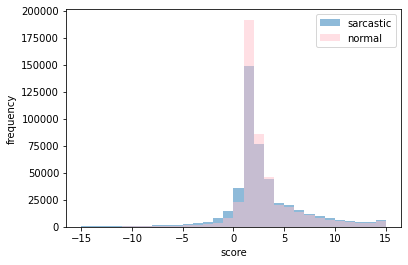

In [18]:
scores_sarc = df["score"][df["label"] == 1]
scores_norm = df["score"][df["label"] == 0]
bins = list(range(-15, 16))
plt.hist(scores_sarc, bins=bins, alpha=0.5, label="sarcastic")
plt.hist(scores_norm, bins=bins, alpha=0.5, color = "pink", label="normal")
plt.xlabel("score")
plt.ylabel("frequency")
plt.legend(loc="upper right")
plt.show()

From the given data, it's clear that it is balanced, since the number of 1 and 0 labeled objects is very near.


## Exploratory Analysis

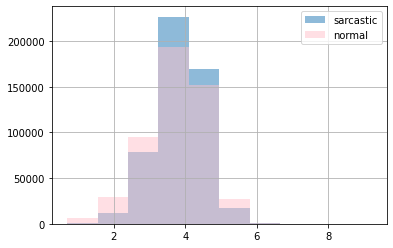

In [19]:
df.loc[df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
df.loc[df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', color = "pink", alpha=.5)
plt.legend();

Distribution of lengths for sarcastic and normal comments is almost the same. 

I would like to create a wordcloud to see what words occur in the dataset:

In [20]:
pip install wordcloud

In [0]:
from wordcloud import WordCloud, STOPWORDS

In [0]:
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

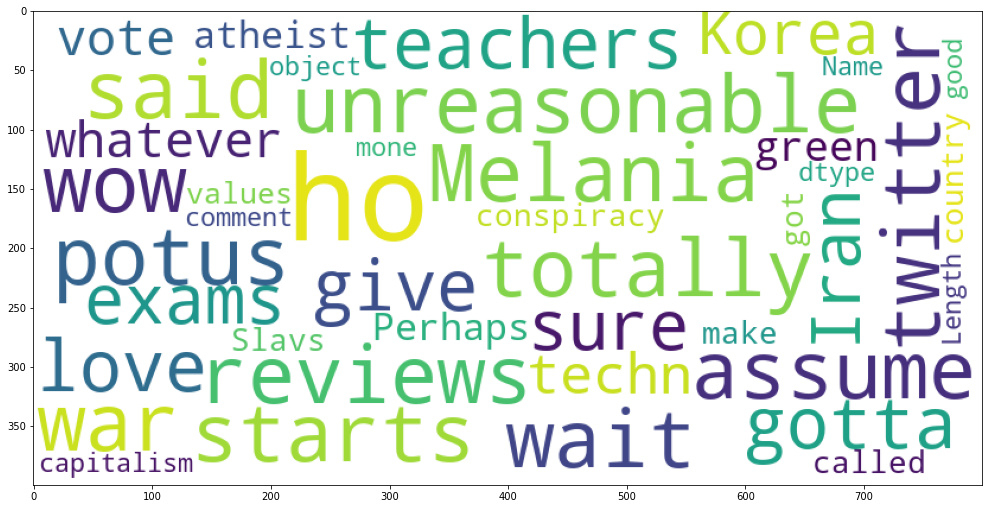

In [23]:
plt.figure(figsize=(17, 12))
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

From the wordcloud we see that some words, but they don't help us much in any way. Let's check the 0 label.

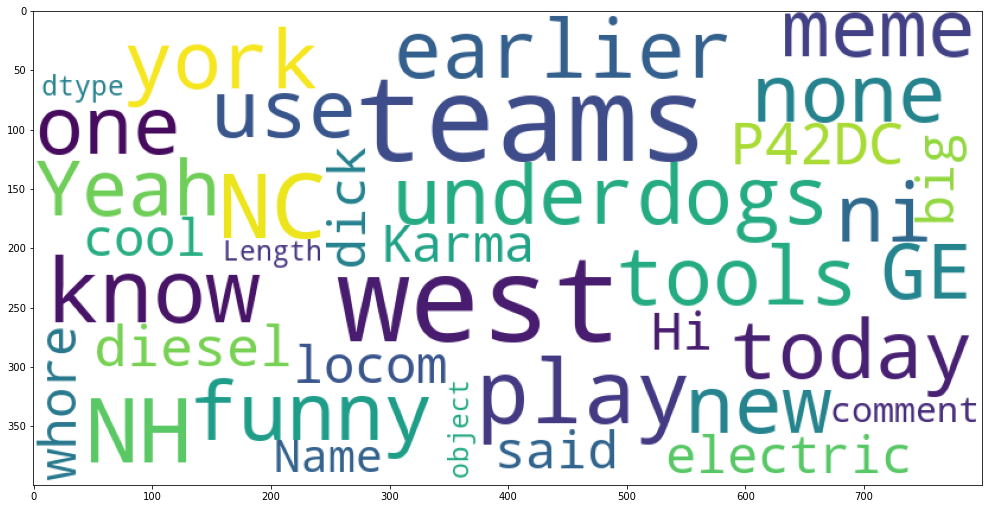

In [24]:
plt.figure(figsize=(17, 12))
wordcloud.generate(str(df.loc[df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

In [25]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [0]:
from nltk.corpus import words
word_list = words.words()

In [27]:
def gen_freq(comment):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in comment.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 30 words
    word_freq[:30]
    
    return word_freq

gen_freq(df.comment.str)

the                367615
a                  236417
to                 233411
I                  166302
and                159431
                    ...  
(&amp;                  1
ELIte                   1
Solicitation            1
shoulders/arms,         1
Manchester"             1
Length: 497257, dtype: int64

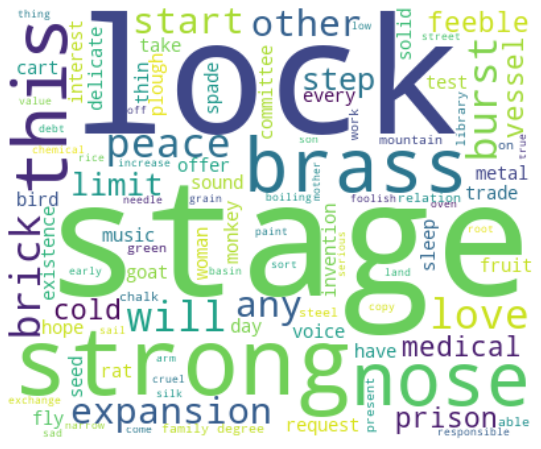

In [28]:
#Generate word cloud from frequent words 

word_freq = pd.Series(word_list).value_counts()

wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Hmm, created this with hope that it may be useful some day...

Now let's start asking questions about the features. For example, I wonder if there are some subreddits that are more sarcastic than others.

To answer this question, I will calculate the percentage of sarcastic comments in each subreddit. But first, let's see how many different unique subreddits we have.

In [29]:
len(df["subreddit"].unique())

14876

Wow, many! Let's take a sample of 25% to see what we have:

In [0]:
top_subreddits = df["subreddit"].value_counts()[0:25]
top_subreddits = list(top_subreddits.index)

In [31]:
sub_df = df[df["subreddit"].isin(top_subreddits)].groupby("subreddit").agg({"label" : "mean"})
sub_df

,label
subreddit,
AdviceAnimals,0.560822
AskReddit,0.401453
CFB,0.513195
DotA2,0.493478
GlobalOffensive,0.552045
The_Donald,0.462640
TumblrInAction,0.609766
WTF,0.456790
atheism,0.639555


We can see that some subreddits seem much more sarcastic than others. The worldnews subreddit is highest among these with 64% sarcasm, whereas AskReddit is lowest with 40%. However, it may not mean that they're the most "sarcastic guys" here. Why?- Because its just a small sample and we cannot judge just by looking at it. We can say that they are some of the most sarcastic in our dataset. And it may be true that, as a whole, they tend to be more sarcastic than others. However, we cannot accept that the proportions we have calculated are representative of the whole subreddits.


Let's now check the same for authors:

In [32]:
sub_df = df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


Now the score:

In [33]:
sub_df = df[df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [34]:
sub_df = df[df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


I think it's time to split the data into test and train. I set the test size to be 0.25, which means that the resulting test set will consist of 25% of the original data set, and the training set will be the remaining 75% :

In [35]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)
test_df.shape

(252694, 10)

## Training Models

 In this part we are going to train our models. For this purpose we should make sure we understand what we work with- text, of course. And for that purpose I would like to highlight that the most important part we will work with will be the "Comment" section. This is why I will separate it, but before that I need to import libraries again and call my train and test sets.

In [0]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import os

In [0]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

In [38]:
test_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
665355,1,this clearly wearing baggy clothing should mea...,Turboswaggg,GlobalOffensive,-7,-7,0,2015-06,2015-06-30 10:10:24,if I shot a guy through his clothing he wouldn...
773140,0,"If your last name was Gary, why would your par...",TheWayoftheFuture,CFB,7,7,0,2014-12,2014-12-04 01:44:29,"It really does smell, doesn't it? I wish it we..."
507645,1,because everyone's buying,holysocks,nyc,2,2,0,2015-12,2015-12-10 18:39:09,There Haven't Been This Many Vacant Rentals in...
646008,0,It's all fun and games until they claim to sme...,NorthATXGuy,Austin,47,47,0,2015-12,2015-12-24 01:24:57,Wilco PD Pulling Over Good Drivers to Distribu...
661080,1,Clearly not a true American,zrowny,AskReddit,1,1,0,2014-11,2014-11-06 00:23:23,I knew that. Why did I type the other thing?


In [39]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
61809,0,"Not drafting Reed, Olsen, or Gronk at where th...",tykulton,fantasyfootball,2,-1,-1,2016-12,2016-12-21 23:35:45,"What is your ""one rule"" for the draft next sea..."
509675,1,Don't you just love the FPTP.,Gardengran,canada,1,1,0,2016-01,2016-01-10 01:51:50,And in Canada 27% voted for the Liberals so th...
132418,1,"The question is why Chief Delphi, TBA, and the...",BellLabs,FRC,11,-1,-1,2016-11,2016-11-23 16:13:51,Why am I not surprised anymore.
183253,0,"easier gold farm is warrior Bolster, Target Du...",Nickster357a,hearthstone,1,1,0,2016-09,2016-09-15 00:41:22,lol been playing this for an hour just farming...
190605,1,What a cuck!,somenbjorn,ShitWehraboosSay,2,2,0,2016-07,2016-07-27 15:28:02,"At least Sparks, if that's even his real name,..."


In [40]:
train_comments = train_df["comment"]
train_comments.head()

61809     Not drafting Reed, Olsen, or Gronk at where th...
509675                        Don't you just love the FPTP.
132418    The question is why Chief Delphi, TBA, and the...
183253    easier gold farm is warrior Bolster, Target Du...
190605                                         What a cuck!
Name: comment, dtype: object

So, now is the show time! We should make sure the machine understands our words in comments, but how? The first thing we need to do is to vectorize this text so that instead of working with words, since our model can work with numbers. We will do this by creating a bag of words representation for each comment. We take a look at all the words in all of the comments and make those the columns of our new feature matrix. Then, we count how many times each word appears in each comment and place those values in the appropriate spots in the matrix. We can use the CountVectorizer to accomplish this. There are several different parameters that we can play with, but for now I'll only set max_features=20000 so that we can save some computation time.

In [42]:
vect = CountVectorizer(max_features=20000)
train_bow = vect.fit_transform(train_comments)
train_bow.shape

(758079, 20000)

As you see, I have now created a training matrix with 20,000 feature columns and 758,079 comment rows. If we try examining a row of this matrix as we normally would, we wouldn't get much out of it, because the matrix is very sparse, meaning that it has a lot of 0 values. This makes sense, because each comment is only going to have a few out of those 20,000 words.

Next, we'll start with an untuned LogisticRegression model, so that we can compare the results to our attempts in the previous notebook. I will only set the random_state=42 as I previously did. Then, I'll cross validate it with 3 folds to get some accuracy values.

In [43]:
log_reg_model = LogisticRegression(random_state=42)
cross_validate(log_reg_model, train_bow, train_df["label"], cv=3, scoring="accuracy", n_jobs=-1)

{'fit_time': array([12.85157514, 13.02088571,  8.57325506]),
 'score_time': array([0.06620002, 0.06177759, 0.04366183]),
 'test_score': array([0.69039111, 0.68786235, 0.68983708])}

Ugh, thanks God, I was already falling asleep..  Our Logistic Regression model can achieve 69% accuracy. That's the power of text data. But are there things we can try to improve on this further.

First, let's start by taking a closer look at some of the parameters in our CountVectorizer. The first parameter I want to set is strip_accents='unicode', which will remove accented letters from the comments are replace them with unaccented ones.

Next, we can see that the vectorizer has built-in functionality to remove stopwords, or words that are so common in the English language so as to be useless in classification. Though we can set the stopwords list to be the pre-built one, it may remove words that might be useful to us;therefore, I will create my own.

The next useful feature is ngram_range, which allows us to use not only single words, but also multi-word phrases (called ngrams) as features. By default, it's set to (1, 1), which means we only use ngrams of length 1 (i.e. single words, or unigrams). We can set it to (1, 2) to use unigrams and bigrams, or higher numbers if they are useful. I will save this for cross validation.

We then have two closely-related parameters we can play with: min_df and max_df. These parameters allow us to automatically disregard words that occur in a certain number of comments. For example, words that appear in only a tiny fraction of the comments would not be very representative and may not be useful for classification. Likewise, words that appear in most comments will not be that useful either.

I will set max_df=0.70, which will throw out all words that occur in more than 70% of comments. This makes sense to me because about 50% are sarcastic and 50% are not, so a word will be useful if it mostly occurs only in sarcastic comments or only in non-sarcastic ones, hence a maximum percentage close to 50%. I will set min_df=0.0001, because words that occur only in 75 out of over 758,000 comments do not have a high chance of being useful.

The last useful parameter I will consider is max_features, which controls the maximum number of words we will retain as features in our new feature matrix. By setting max_df and min_df we will be able to limit the number of features we have. However, once we start considering bigrams, trigrams, and (maybe) beyond, we will once again have an enormous list. I will limit the number of features we keep to 50,000 or less. This is another parameter we can potentially configure with cross validation.

Let's create our list of stopwords and our vectorizer based on those settings.

In [44]:
stopwords = ["the", "a", "an", "she", "he", "i", "you", "me", "they",
             "her", "his", "your", "their", "my", "we", "our", "ours",
             "hers", "yours", "it", "its", "him", "them", "theirs",
             "this", "that", "is", "was", "are", "were", "am", "or",
             "as", "of", "at", "by", "for", "with", "to", "from", "in",
             "m", "s", "ve", "d", "ll", "o", "re"]

vect = CountVectorizer(strip_accents='unicode', stop_words=stopwords, min_df=0.0001, max_df=0.70)
train_bow = vect.fit_transform(train_comments)
train_bow.shape

(758079, 6450)

### TfidfTransformer

The next step is to use a TfidfTransformer to transform the matrix of counts into a matrix of scaled term frequencies.

In [45]:
tf_trans = TfidfTransformer()
train_tf = tf_trans.fit_transform(train_bow)
train_tf.shape

(758079, 6450)

## Models

### Logistic Regression


In [0]:

vect = CountVectorizer(strip_accents='unicode', stop_words=stopwords, min_df=0.0001, max_df=0.70)
tf_trans = TfidfTransformer()


log_reg_model = LogisticRegression(random_state=42, penalty="elasticnet", solver="saga")

pipeline = Pipeline([
    ('vect', vect),
    ('tftrans', tf_trans),
    ('model', log_reg_model)
])

In [0]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_features': (5000, 10000, 20000),
    'model__l1_ratio': (0.0, 0.25, 0.50, 0.75, 1.0)
}

grid_logreg = GridSearchCV(pipeline, param_grid, scoring="accuracy", cv=3, n_jobs=-1)
grid_logreg.fit(train_comments, train_df["label"])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In this part I use cross validation with GridSearchCV. A daamn long process, please kill me

In [0]:
print(grid_logreg.best_score_)
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, grid_logreg.best_params_[param_name]))

### Logistic Regression Results
After this grid search finally finishes running, we can see that the best model it found had 15,000 max features, an n-gram range of (1, 3), and an l1_ratio of ----. This model achieved an accuracy of ----. We can possibly improve upon this by trying more different values for the parameters in a more granular range. However, we also have two other models to attempt.

### Naive Bayes
The Naive Bayes classifier is one that is based on probability using Bayes' theorem. The particular type of Naive Bayes I am using is Multinomial Naive Bayes, which is good for working with text datasets like the one we have.

The only parameter to modify here would be alpha, which controls the smoothing of probabilities, but I will leave it at the default value of 1.

In [0]:

vect = CountVectorizer(strip_accents='unicode', stop_words=stopwords, min_df=0.0001, max_df=0.70)
tf_trans = TfidfTransformer()

# creating the NB model
nb_model = MultinomialNB()

pipeline = Pipeline([
    ('vect', vect),
    ('tftrans', tf_trans),
    ('model', nb_model)
])

In this case, our grid search will only have 9 combinations of parameters to try and will only have to train and test 27 times.

In [0]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_features': (5000, 15000, 30000)
}

grid_nb = GridSearchCV(pipeline, param_grid, scoring="accuracy", cv=3, n_jobs=-1)
grid_nb.fit(train_comments, train_df["label"])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.7,
                                                        max_features=None,
                                                        min_df=0.0001,
                                                        ngram_range=(1, 1),
                                                       

In [0]:
print(grid_nb.best_score_)
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, grid_nb.best_params_[param_name]))

0.6865353083253857


KeyError: ignored

### Naive Bayes Results
The results show that the best classifier achieved a maximum accuracy of 69% with 15,000 features that include uni-, bi-, and trigrams. This is just about the same as the Logistic Regression classifier above. One option we have is to add some sort of feature selection step to reduce the number of features we train on. The Logistic Regression classifier did this as part of the training process (due to the l1_ratio allowing for some Lasso regularization), but the Naive Bayes classifier would need this to be done explicitly. But first, we can try the Support Vector Machine.

### Support Vector Machine
Support Vectore Machine models are basically drawing a line to divide one class of data points from the other. The trick is finding the best line. In particular, we will be using an SVM solved by Stochastic Gradient Descent, which is an approach used to train linear classifiers with a convex cost function.

There are lots of parameters to modify in the SGDClassifier. We can change the type of loss function and type of penalty term we use. We can change the l1_ratio that has to do with the regularization penalty as well, the number of iterations to permit and the tolerance for the stopping condition, we can also change how to determine the learning rate and various constants that are relevant to the mathematically formulae that define the SVM.

In [0]:

vect = CountVectorizer(strip_accents='unicode', stop_words=stopwords, min_df=0.0001, max_df=0.70)
tf_trans = TfidfTransformer()

# creating the SVM model
svm_model = SGDClassifier(penalty="elasticnet", random_state=42, n_jobs=-1)

pipeline = Pipeline([
    ('vect', vect),
    ('tftrans', tf_trans),
    ('model', svm_model)
])

In [0]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_features': (5000, 15000, 30000),
    'model__l1_ratio': (0.0, 0.15, 0.40, 0.60, 0.85, 1.0)
}

grid_svm = GridSearchCV(pipeline, param_grid, scoring="accuracy", cv=3, n_jobs=-1)
grid_svm.fit(train_comments, train_df["label"])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.7,
                                                        max_features=None,
                                                        min_df=0.0001,
                                                        ngram_range=(1, 1),
                                                       

In [0]:
print(grid_svm.best_score_)
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, grid_svm.best_params_[param_name]))

0.6764743516177073
model__l1_ratio: 0.0
vect__max_features: 15000
vect__ngram_range: (1, 3)


### Support Vector Machine Results
Our results show that the best model as determined by our grid search achieved 0.68 accuracy, with l1_ratio=0 (indicating Ridge regularization) and a list of 15,000 uni-, bi-, and trigrams. This is below the accuracy of the other models, but since the difference is very slight it may not be significant.

All three of the models we tried agreed upon 15,000 features and the inclusion of bi- and trigrams. If we were to continue running grid search to select a model, we could try running it with max_feature values of 10,000, 15,000, 20,000, and 25,000. We may also decide to try 4-grams.

There are also other ways we can modify the SVM model. In particular, the SGDClassifier is limited to a linear kernel function because it uses Stochastic Gradient Descent. 

#### Training the Final Model
 I will choose Naive Bayes because it trains much faster on our dataset. Let's create our final pipeline and train our final model.

In [0]:

vect = CountVectorizer(strip_accents='unicode', stop_words=stopwords, min_df=0.0001, max_df=0.70, max_features=15000, ngram_range=(1, 3))
tf_trans = TfidfTransformer()

# creating the NB model
nb_model = MultinomialNB()

pipeline = Pipeline([
    ('vect', vect),
    ('tftrans', tf_trans),
    ('model', nb_model)
])

pipeline.fit(train_comments, train_df["label"])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.7,
                                 max_features=15000, min_df=0.0001,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=['the', 'a', 'an', 'she', 'he', 'i',
                                             'you', 'me', 'they', 'her', 'his',
                                             'your', 'their', 'my',...
                                             'ours', 'hers', 'yours', 'it',
                                             'its', 'him', 'them', 'theirs',
                                             'this', 'that', 'is', 'was', 'are',
                                             'were', ...],
          

In [0]:
#making predictions

test_comments = test_df["comment"]
preds = pipeline.predict(test_comments)
preds.shape

(252694,)

In [0]:
acc = accuracy_score(test_df["label"], preds)
acc

0.6871750021765456

The final accuracy for this model is 69%, which agrees with the accuracy we got during cross-validation. This is good, it means we probably didn't overfit our model.

In [0]:
confusion_matrix(test_df["label"], preds) / test_df.shape[0]

array([[0.37421545, 0.12459338],
       [0.18823162, 0.31295955]])

From this confusion matrix, we can understand that we are a little better at classifying non-sarcastic comments than sarcastic comments. Since both classes are 50% of the dataset, we can see that 6% more comments were correctly classified as non-sarcastic (37% of total comments) compared to sarcastic (31% of total comments). We can also see that the non-sarcastic label was more popular overall: summing down the first column shows us that about 56% of all test points were classified as non-sarcastic.

Next, if it doesn't take too long, I will check other models too.